Target ["Status"] = Probability of fatality of patient

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde

df = pd.read_csv('/content/combiend_train_liver_cirrhosis_datasets.csv')

# Converting NA to NaN values
df.replace('NA', np.nan, inplace=True)

In [4]:
# Numeric & Cateorical Values

categorical_columns = []
numeric_columns = []

for column in df:
    if df[column].dtype == 'object':
        categorical_columns.append(column)
    else:
        numeric_columns.append(column)

print(f"Categorical Columns : {categorical_columns}")
print(f"Numeric Columns : {numeric_columns}")

Categorical Columns : ['Drug', 'Sex', 'Ascites', 'Hepatomegaly', 'Spiders', 'Edema', 'Status']
Numeric Columns : ['index', 'id', 'N_Days', 'Age', 'Bilirubin', 'Cholesterol', 'Albumin', 'Copper', 'Alk_Phos', 'SGOT', 'Tryglicerides', 'Platelets', 'Prothrombin', 'Stage']


In [5]:
# NaN Values

print("NaN Values:")


for column in df:
    NaN_counts = df[f"{column}"].isna().sum()
    if NaN_counts != 0:
        print(column, ":", NaN_counts)
    else:
        pass

NaN Values:
id : 25000
Status : 5271


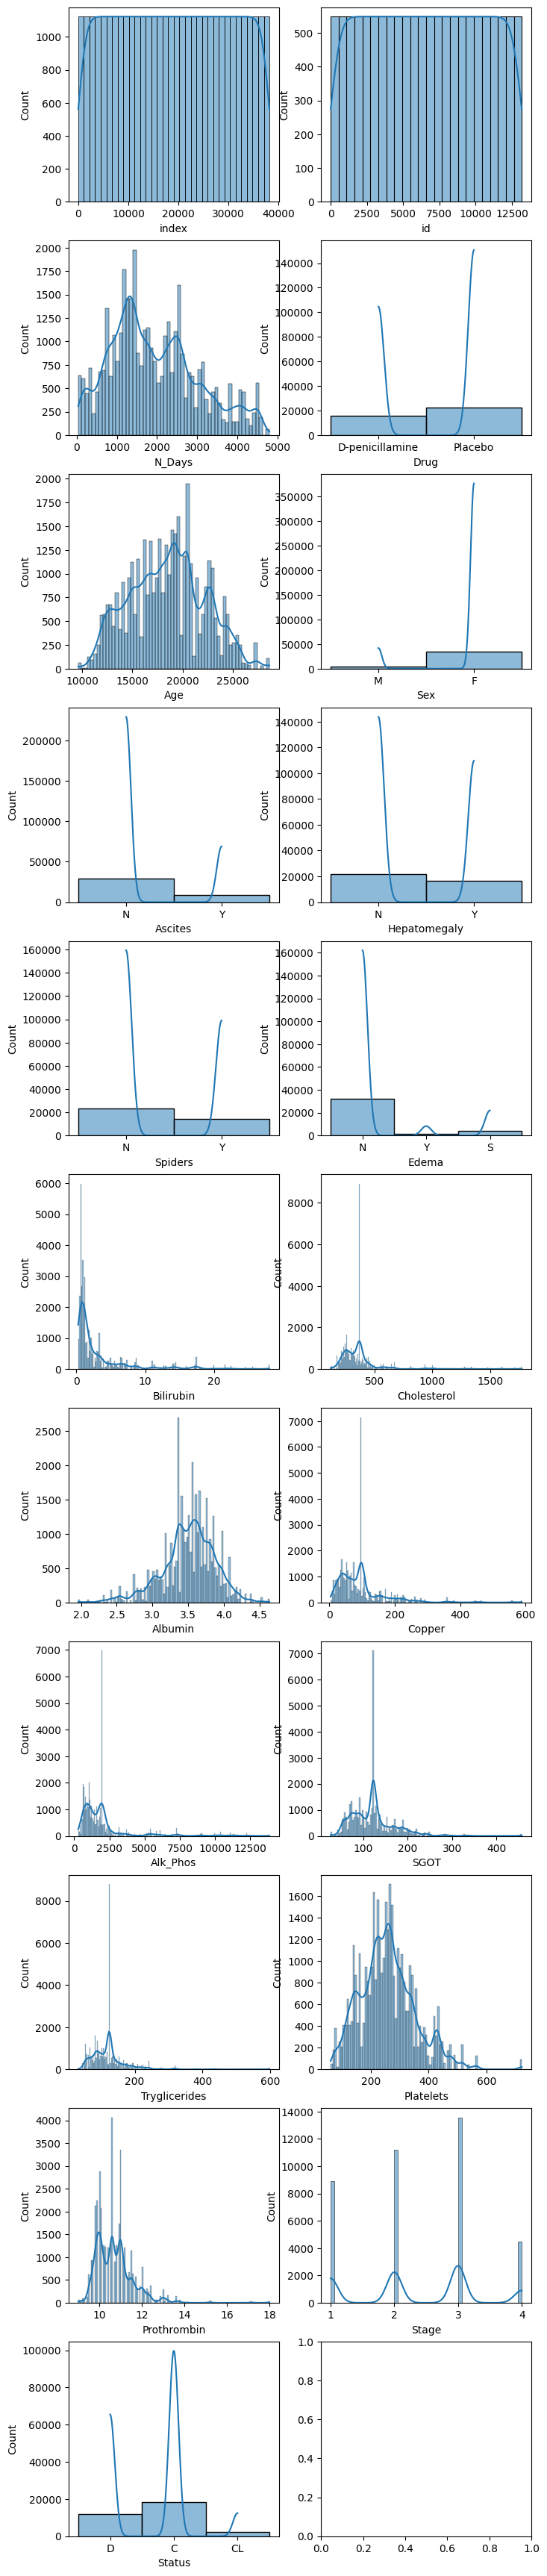

In [6]:
# Hitograph

import seaborn as sns
rows = (len(df.columns)+1)//2
_, axes = plt.subplots(rows, 2, figsize = (8, rows*4))
for i, col in enumerate(df.columns):
    hor = i%2
    ver = i//2
    sns.histplot(data = df[col], kde = True, ax = axes[ver, hor])

Imputation & Scaling

In [7]:
# Categorical Encoding - Simple Imputer, Onehot Encoder, Label Encoder

import numpy as np
import pandas as pd
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, LabelEncoder

# 1. Imputing categorical variables
cat_imputer = SimpleImputer(missing_values=np.nan, strategy='most_frequent')
df[categorical_columns] = cat_imputer.fit_transform(df[categorical_columns])

# 2. Encoding categorical variables
# Removing 'Status' to apply Label Encoding only on the target variable
categorical_columns.remove('Status')

# One-hot encode all other categorical columns
onehot_encoder = OneHotEncoder(handle_unknown='ignore', sparse_output=False)
one_hot_encoded = onehot_encoder.fit_transform(df[categorical_columns])

df = pd.concat([df.drop(columns=categorical_columns),
                pd.DataFrame(one_hot_encoded, columns=onehot_encoder.get_feature_names_out(categorical_columns))], axis=1)

# 3. Label encoding for the target variable 'Status'
label_encoder = LabelEncoder()
df['Status'] = label_encoder.fit_transform(df['Status'])


In [8]:
# Numeric Imputer - Iterative Imputer, Standard Scaler
import numpy as np
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.impute import KNNImputer
from sklearn.preprocessing import StandardScaler, RobustScaler

# 1. Imputing numeric variables using Iterative Imputer
numeric_imputer = IterativeImputer(missing_values=np.nan, max_iter=30)
df[numeric_columns] = numeric_imputer.fit_transform(df[numeric_columns])

# # Knn imputer - 89% for given data
# numeric_knn_imputer = KNNImputer(missing_values=np.nan, n_neighbors=20)
# df[numeric_columns] = numeric_knn_imputer.fit_transform(df[numeric_columns])

# 2. Scaling numeric columns
# scaler = StandardScaler()
# df[numeric_columns] = scaler.fit_transform(df[numeric_columns])

# Robust Scaler
robust_scaler = RobustScaler()
df[numeric_columns] = robust_scaler.fit_transform(df[numeric_columns])


Outliers

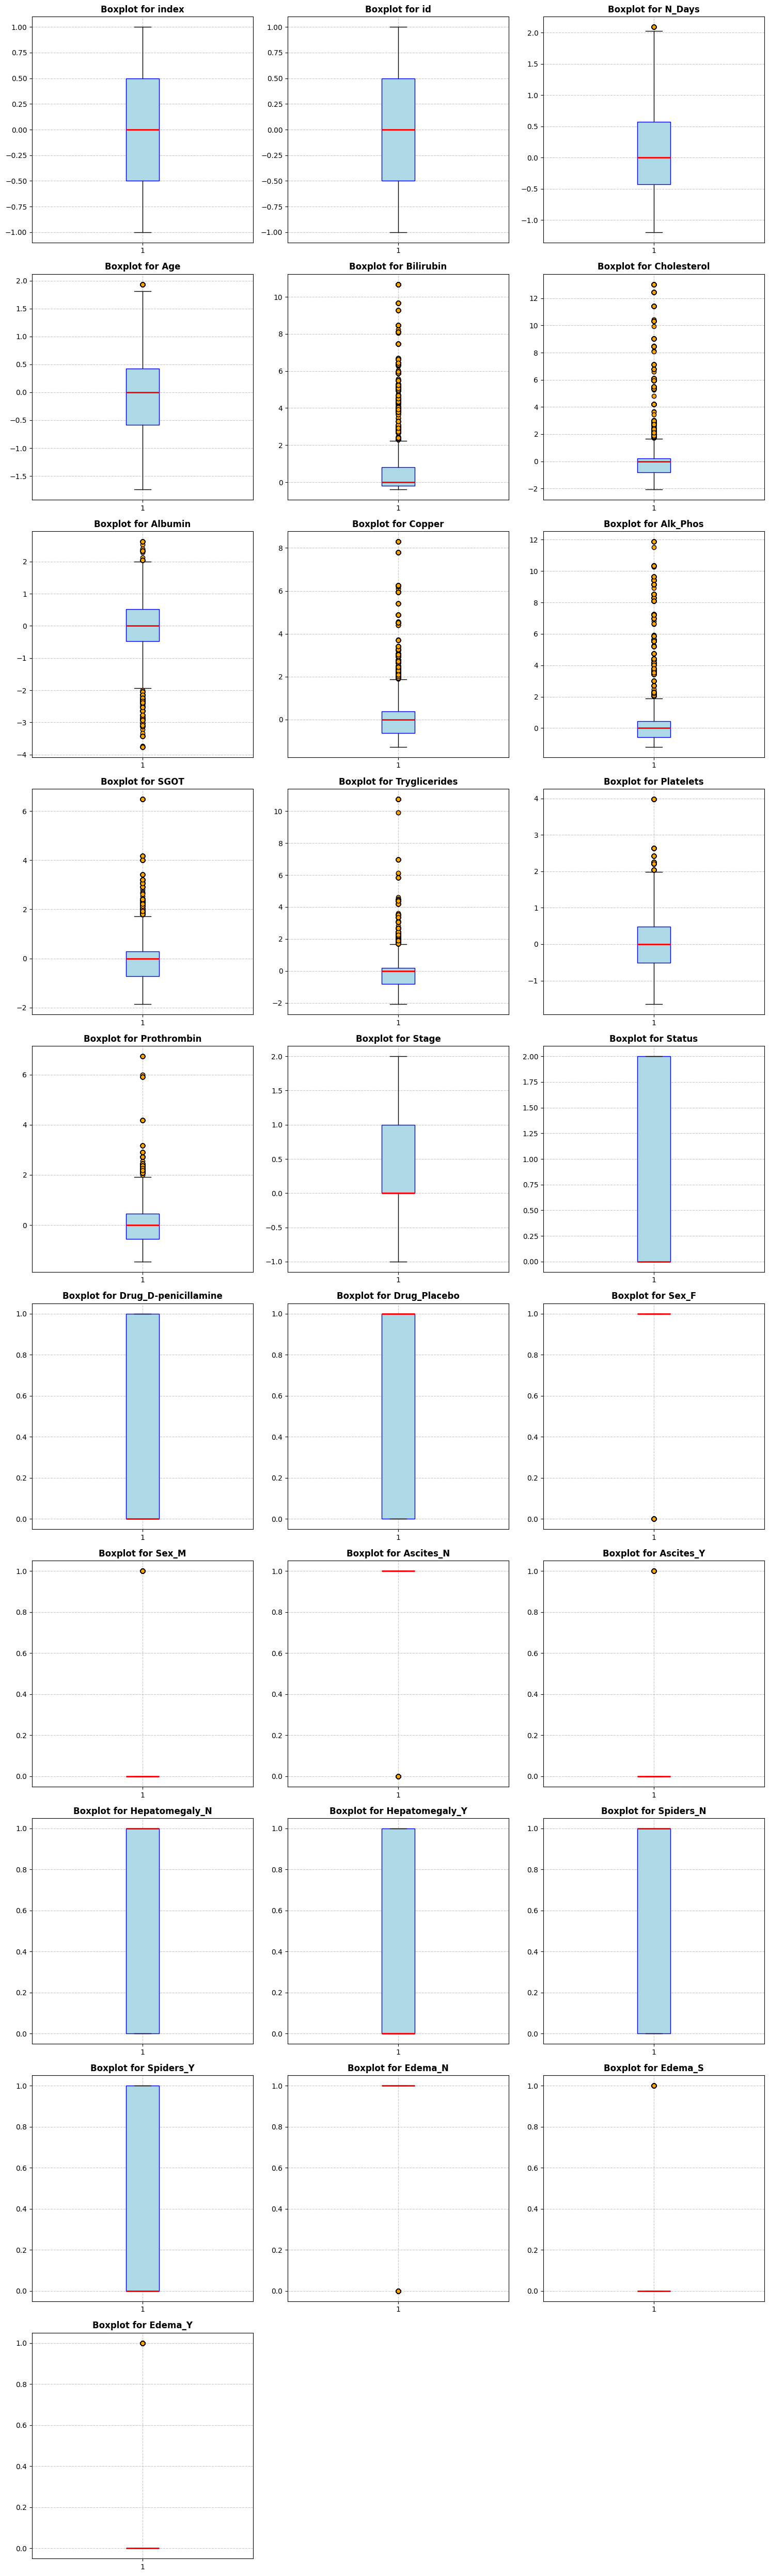

In [10]:
# Box Plot

import matplotlib.pyplot as plt

def plot_boxplots_as_subplots(df):
    num_columns = len(df.columns)
    n_cols = 3  # Number of plots per row (adjust as needed)
    n_rows = (num_columns + n_cols - 1) // n_cols  # Calculate number of rows needed

    # Create a figure with subplots
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, n_rows * 5))
    axes = axes.flatten()  # Flatten the axes to easily iterate over them

    # Loop through each column and plot the boxplot
    for i, column in enumerate(df.columns):
        axes[i].boxplot(
            df[column],
            patch_artist=True,
            boxprops=dict(facecolor="lightblue", color="blue"),
            medianprops=dict(color="red", linewidth=2),
            flierprops=dict(marker="o", markerfacecolor="orange", markersize=6, linestyle="none")
        )
        axes[i].set_title(f"Boxplot for {column}", fontsize=12, fontweight="bold")
        axes[i].grid(True, linestyle="--", alpha=0.7)

    # Hide any unused subplots
    for j in range(i + 1, len(axes)):
        fig.delaxes(axes[j])

    # Adjust layout to prevent overlap
    plt.tight_layout()
    plt.show()

# Example usage:
plot_boxplots_as_subplots(df)


In [11]:
import pandas as pd
import numpy as np

def remove_outliers_iqr(df, columns, threshold=1.5):
    """
    Removes outliers from specified columns in a DataFrame using the IQR method.

    Parameters:
    df (pd.DataFrame): Input DataFrame
    columns (list): List of column names to check for outliers
    threshold (float): IQR multiplier (default is 1.5, standard for mild outliers)

    Returns:
    pd.DataFrame: DataFrame with outliers removed
    """
    df_cleaned = df.copy()
    for col in columns:
        if df[col].dtype in ['int64', 'float64']:  # Apply only to numerical columns
            Q1 = df[col].quantile(0.25)
            Q3 = df[col].quantile(0.75)
            IQR = Q3 - Q1
            lower_bound = Q1 - threshold * IQR
            upper_bound = Q3 + threshold * IQR
            df_cleaned = df_cleaned[(df_cleaned[col] >= lower_bound) & (df_cleaned[col] <= upper_bound)]

    return df_cleaned

numerical_columns = ["Bilirubin", "Cholesterol", "Copper", "SGOT", "Alk_Phos", "Tryglicerides", "Prothrombin"]
df= remove_outliers_iqr(df, numerical_columns)

In [12]:
df['Status'].value_counts()

,count
Status,
0,18559
2,5299
1,1716


# Modeling

XGBClasClasClasClasClasClassifiersClassifiersoost

In [13]:
TARGET = 'Status'

In [14]:
df.columns.to_list()

['index',
 'id',
 'N_Days',
 'Age',
 'Bilirubin',
 'Cholesterol',
 'Albumin',
 'Copper',
 'Alk_Phos',
 'SGOT',
 'Tryglicerides',
 'Platelets',
 'Prothrombin',
 'Stage',
 'Status',
 'Drug_D-penicillamine',
 'Drug_Placebo',
 'Sex_F',
 'Sex_M',
 'Ascites_N',
 'Ascites_Y',
 'Hepatomegaly_N',
 'Hepatomegaly_Y',
 'Spiders_N',
 'Spiders_Y',
 'Edema_N',
 'Edema_S',
 'Edema_Y']

<ipython-input-15-0d985f14b038>:26: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=y_train_before, palette="Set2")
<ipython-input-15-0d985f14b038>:38: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=y_train, palette="Set1")


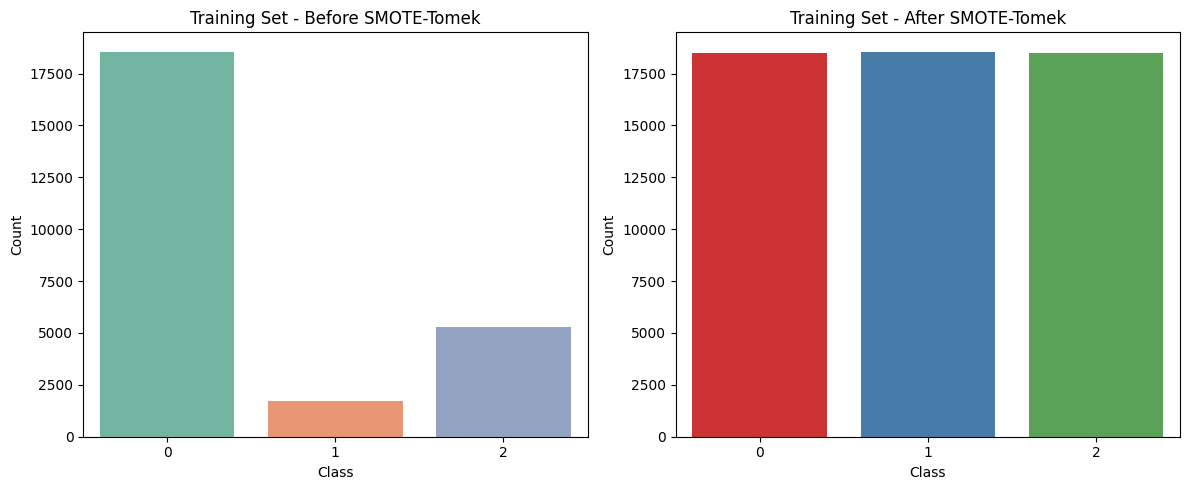

In [15]:
import pandas as pd
import torch
from sklearn.model_selection import train_test_split
from imblearn.combine import SMOTETomek
from sklearn.preprocessing import RobustScaler
from sklearn.decomposition import PCA

# Load and prepare data
preprocessed_cirrhosis = pd.read_csv('/content/cirrhosis_preprocessed.csv')
preprocessed_cirrhosis = preprocessed_cirrhosis.drop(['ID'], axis=1)

# Removing unwated columns from the training dataset
df = df.drop(['index', 'id'], axis=1)

# Split into train/test sets based on original
X_train, y_train = df.drop(['Status'], axis=1), df['Status']
X_test, y_test = preprocessed_cirrhosis.drop(['Status'], axis=1), preprocessed_cirrhosis['Status']

y_train_before = y_train.copy()


# Plot class distribution before SMOTE-Tomek
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
sns.countplot(x=y_train_before, palette="Set2")
plt.title("Training Set - Before SMOTE-Tomek")
plt.xlabel("Class")
plt.ylabel("Count")

# Apply SMOTE-Tomek to balance classes
smote_tomek = SMOTETomek(random_state=42, n_jobs=-1)
X_train, y_train = smote_tomek.fit_resample(X_train, y_train)


# Plot class distribution after SMOTE-Tomek
plt.subplot(1, 2, 2)
sns.countplot(x=y_train, palette="Set1")
plt.title("Training Set - After SMOTE-Tomek")
plt.xlabel("Class")
plt.ylabel("Count")

plt.tight_layout()
plt.show()

# Scaling the data
scaler = RobustScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Apply PCA
n_pca_components = 25
pca = PCA(n_components=n_pca_components)
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)


In [17]:
import xgboost as XGBClassifer
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score, classification_report

import optuna

def objective(trial):
    param = {
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.1),
        'n_estimators': trial.suggest_int('n_estimators', 100, 1000),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
        'gamma': trial.suggest_float('gamma', 0, 5),
    }

    # initializing the XGBoost model
    model = XGBClassifer.XGBClassifier(**param,
                              tree_method = 'hist',
                              device = 'cuda')

    score = cross_val_score(model, X_train, y_train, cv=3, n_jobs=-1).mean()
    return score


# Create and run the optimization process with 100 trials
study = optuna.create_study(study_name="xgboost_study", direction='maximize')
study.optimize(objective, n_trials=100, show_progress_bar=True, n_jobs=-1)

# Retrieve the best parameter values
best_params = study.best_params
print(f"\nBest parameters: {best_params}")

[I 2025-04-30 10:36:21,908] A new study created in memory with name: xgboost_study


  0%|          | 0/100 [00:00<?, ?it/s]

[I 2025-04-30 10:36:41,708] Trial 0 finished with value: 0.9300567537295866 and parameters: {'max_depth': 9, 'learning_rate': 0.09180522793984375, 'n_estimators': 366, 'subsample': 0.5515324831233892, 'colsample_bytree': 0.6264882752504553, 'min_child_weight': 7, 'gamma': 3.2916500626738365}. Best is trial 0 with value: 0.9300567537295866.
[I 2025-04-30 10:36:43,377] Trial 1 finished with value: 0.8966868002900606 and parameters: {'max_depth': 3, 'learning_rate': 0.03256903415864931, 'n_estimators': 637, 'subsample': 0.881544816851201, 'colsample_bytree': 0.8989507000611738, 'min_child_weight': 1, 'gamma': 4.6890939157856515}. Best is trial 0 with value: 0.9300567537295866.
[I 2025-04-30 10:36:47,167] Trial 2 finished with value: 0.9171335465364293 and parameters: {'max_depth': 4, 'learning_rate': 0.08885405689305712, 'n_estimators': 210, 'subsample': 0.7464728502573756, 'colsample_bytree': 0.8529295241203826, 'min_child_weight': 1, 'gamma': 1.4746185484741399}. Best is trial 0 with va

Training the tuned hyperparmeter model

In [18]:
# Train the model with the best parameters
best_xgb_model = XGBClassifer.XGBClassifier(**best_params)
best_xgb_model.fit(X_train, y_train)

# Predict the test data
y_pred = best_xgb_model.predict(X_test)

# Calculate the accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy}")

# Generate a classification report
cr = classification_report(y_test, y_pred)
print(f"\nReport:\n{cr}")

Accuracy: 0.7416267942583732

Report:
              precision    recall  f1-score   support

           0       0.81      0.76      0.79       232
           1       0.57      0.32      0.41        25
           2       0.67      0.78      0.72       161

    accuracy                           0.74       418
   macro avg       0.69      0.62      0.64       418
weighted avg       0.74      0.74      0.74       418



<Figure size 10000x10000 with 0 Axes>

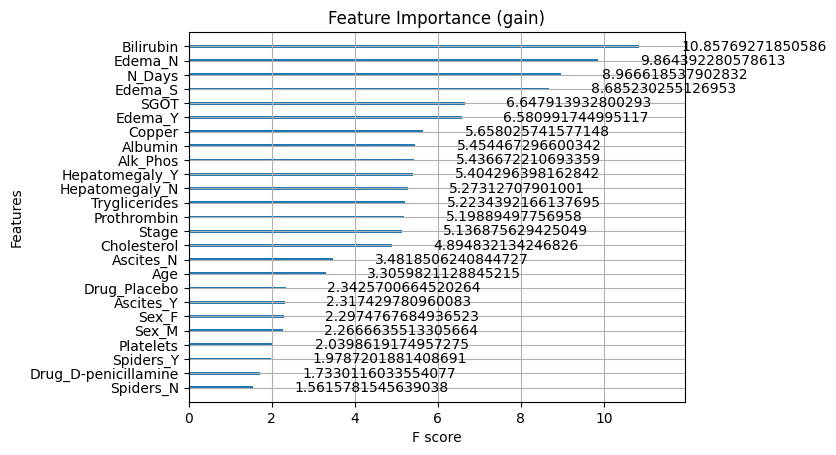

In [19]:
from xgboost import plot_importance
import matplotlib.pyplot as plt

# Plot feature importance
plt.figure(figsize=(100, 100))
plot_importance(best_xgb_model, importance_type='gain', max_num_features=len(df))
plt.title('Feature Importance (gain)')
plt.show()

In [21]:
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score, classification_report
from lightgbm import LGBMClassifier
import optuna

def objective(trial):
    param = {
        'n_estimators': trial.suggest_int('n_estimators', 100, 500),
        'max_depth': trial.suggest_int('max_depth', 3, 12),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3, log=True),
        'num_leaves': trial.suggest_int('num_leaves', 20, 100),
        'min_child_samples': trial.suggest_int('min_child_samples', 1, 50),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
        'reg_alpha': trial.suggest_float('reg_alpha', 1e-8, 10.0, log=True),
        'reg_lambda': trial.suggest_float('reg_lambda', 1e-8, 10.0, log=True),
        'min_split_gain': trial.suggest_float('min_split_gain', 1e-8, 1.0, log=True),
        'scale_pos_weight': trial.suggest_float('scale_pos_weight', 0.1, 10.0, log=True)
    }

    model = LGBMClassifier(**param)

    # Evaluate using cross-validation
    score = cross_val_score(model, X_train, y_train, cv=3, n_jobs=-1).mean()
    return score

# Create and run the optimization process
study = optuna.create_study(study_name="lgbmclassifier_study", direction='maximize')
study.optimize(objective, n_trials=100, show_progress_bar=True, n_jobs=1)  # n_jobs=1 is required for Optuna parallelism

# Retrieve the best parameter values
best_params = study.best_params
print(f"\nBest parameters: {best_params}")


[I 2025-04-30 11:14:58,067] A new study created in memory with name: lgbmclassifier_study


  0%|          | 0/100 [00:00<?, ?it/s]

[I 2025-04-30 11:15:40,523] Trial 0 finished with value: 0.9492256187300253 and parameters: {'n_estimators': 305, 'max_depth': 11, 'learning_rate': 0.013140504978954737, 'num_leaves': 92, 'min_child_samples': 9, 'subsample': 0.7150034927436448, 'colsample_bytree': 0.7119056381290694, 'reg_alpha': 1.7856616565400698e-07, 'reg_lambda': 5.131773607386491e-07, 'min_split_gain': 0.027381117720600465, 'scale_pos_weight': 0.2963568817691084}. Best is trial 0 with value: 0.9492256187300253.
[I 2025-04-30 11:16:13,595] Trial 1 finished with value: 0.9680884392038204 and parameters: {'n_estimators': 302, 'max_depth': 12, 'learning_rate': 0.10229713376808705, 'num_leaves': 78, 'min_child_samples': 15, 'subsample': 0.8977238003870847, 'colsample_bytree': 0.9738428981289464, 'reg_alpha': 2.512588134799457e-07, 'reg_lambda': 6.415378399322704, 'min_split_gain': 0.004656146825628717, 'scale_pos_weight': 0.24581247241296353}. Best is trial 1 with value: 0.9680884392038204.
[I 2025-04-30 11:16:33,260] 

In [22]:
# Train the model with the best parameters
best_LGBM_model = LGBMClassifier(**best_params)
best_LGBM_model.fit(X_train, y_train)

# Predict the test data
y_pred = best_LGBM_model.predict(X_test)

# Calculate the accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy}")

# Generate a classification report
cr = classification_report(y_test, y_pred)
print(f"\nReport:\n{cr}")

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006564 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6123
[LightGBM] [Info] Number of data points in the train set: 55559, number of used features: 25
[LightGBM] [Info] Start training from score -1.099675
[LightGBM] [Info] Start training from score -1.096598
[LightGBM] [Info] Start training from score -1.099567
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further spl


Feature Importances:
                 Feature  Importance
0                 N_Days       11840
4                Albumin       11772
2              Bilirubin       10807
10           Prothrombin        8658
1                    Age        8605
9              Platelets        8605
5                 Copper        8099
7                   SGOT        8094
6               Alk_Phos        7900
8          Tryglicerides        7865
3            Cholesterol        7540
11                 Stage        5021
12  Drug_D-penicillamine        1075
20             Spiders_N         895
18        Hepatomegaly_N         893
22               Edema_N         554
14                 Sex_F         553
19        Hepatomegaly_Y         545
21             Spiders_Y         543
13          Drug_Placebo         526
16             Ascites_N         401
23               Edema_S         345
15                 Sex_M         256
24               Edema_Y         149
17             Ascites_Y         114


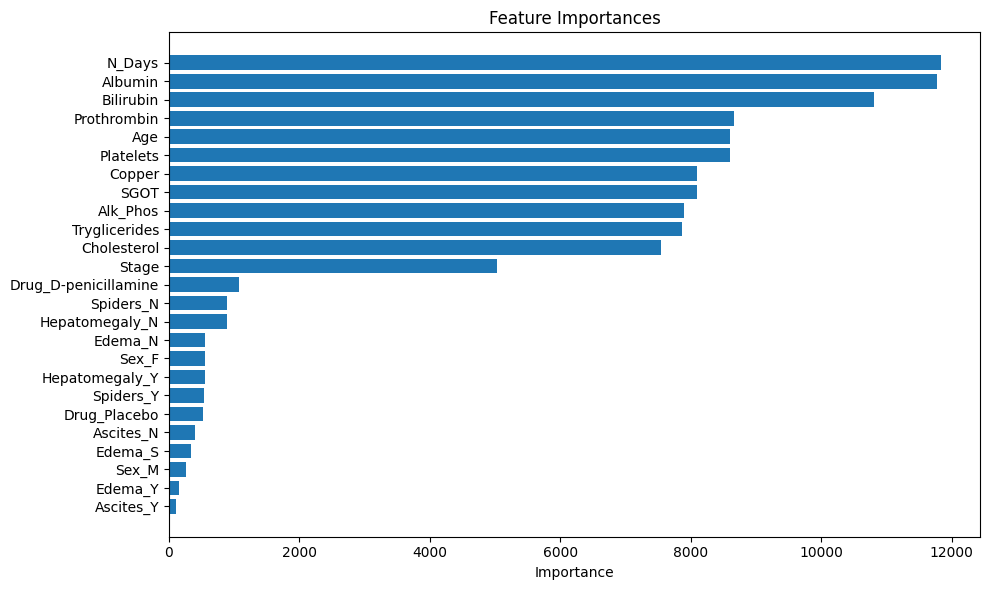

In [23]:
# Feature importance
importances = best_LGBM_model.feature_importances_
feature_names = X_train.columns  # assuming X_train is a DataFrame
importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
importance_df = importance_df.sort_values(by='Importance', ascending=False)

print("\nFeature Importances:")
print(importance_df)

# Plot feature importances
plt.figure(figsize=(10, 6))
plt.barh(importance_df['Feature'], importance_df['Importance'])
plt.xlabel("Importance")
plt.title("Feature Importances")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()